## News Mood

In this assignment, you'll create a Python script to perform a sentiment analysis of the Twitter activity of various news oulets, and to present your findings visually.

Your final output should provide a visualized summary of the sentiments expressed in Tweets sent out by the following news organizations: __BBC, CBS, CNN, Fox, and New York times__.

![output_10_0.png](images/output_10_0.png)

![output_13_1.png](images/output_13_1.png)

The first plot will be and/or feature the following:

* Be a scatter plot of sentiments of the last __100__ tweets sent out by each news organization, ranging from -1.0 to 1.0, where a score of 0 expresses a neutral sentiment, -1 the most negative sentiment possible, and +1 the most positive sentiment possible.
* Each plot point will reflect the _compound_ sentiment of a tweet.
* Sort each plot point by its relative timestamp.

The second plot will be a bar plot visualizing the _overall_ sentiments of the last 100 tweets from each organization. For this plot, you will again aggregate the compound sentiments analyzed by VADER.

The tools of the trade you will need for your task as a data analyst include the following: tweepy, pandas, matplotlib, seaborn, textblob, and VADER.

Your final Jupyter notebook must:

* Pull last 100 tweets from each outlet.
* Perform a sentiment analysis with the compound, positive, neutral, and negative scoring for each tweet.
* Pull into a DataFrame the tweet's source acount, its text, its date, and its compound, positive, neutral, and negative sentiment scores.
* Export the data in the DataFrame into a CSV file.
* Save PNG images for each plot.

As final considerations:

* Use the Matplotlib and Seaborn libraries.
* Include a written description of three observable trends based on the data.
* Include proper labeling of your plots, including plot titles (with date of analysis) and axes labels.
* Include an exported markdown version of your Notebook called  `README.md` in your GitHub repository.


In [69]:
# Dependencies
import tweepy
import pandas as pd
from pprint import pprint
from config import *
import os
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
import matplotlib.pyplot as plt
import seaborn as sns
#import ast
#from time import sleep
from pprint import pprint

# Twitter API Keys
consumer_key = consumer_key
consumer_secret = consumer_secret
access_token = access_token
access_token_secret = access_token_secret

# Twitter credentials
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

## Helpers

In [2]:
def rwCSV(path,rw='r',df=None,columns=None):
    '''
    Reads CSV from path to pandas dataframe (rw='r')
    Writes/appends to CSV path from pandas dataframe (rw='w')
    Columns: array-like
    '''
    if rw=='r':
        if os.path.isfile(path): 
            print('rwCSV: returning DF from CSV')
            return pd.read_csv(path)
        else: 
            print(f'rwCSV: returning new DF with columns: {columns}')
            return pd.DataFrame(columns=columns)
    elif rw=='w':
        df = pd.DataFrame(df)
        # if file does not exist write with header 
        if not os.path.isfile(path):
            df.to_csv(path,index=False, columns=columns)
            print(f"rwCSV: saved {df.shape[0]} row(s) as new file to '{path}'")
        else: # else it exists so append without writing the header
            df.to_csv(path,mode = 'a',header=False,index=False, columns=columns)
            print(f"rwCSV: appended {df.shape[0]} row(s) to '{path}'")

In [36]:
def getTweets(userName,count=100):
    '''
    gets Tweets from twitter and returns DF
    '''
    #set up resulting columns and DF
    columns = ['account', 'text', 'date', 'compound', 'positive', 'neutral', 'negative']

    tweets_df = pd.DataFrame(columns=columns)

    #get tweets
    try: 
        for status in tweepy.Cursor(api.user_timeline, id=userName).items(count):
            
            #jsonify the response
            tweet = status._json
            
            #extract text
            text = tweet['text']
            
            #analyze text
            result = analyzer.polarity_scores(text)
            
            row = {'account':userName,
                   'text':text,
                   'date':tweet['created_at'],
                   'compound':result['compound'],
                   'positive':result['pos'],
                   'neutral':result['neu'],
                   'negative':result['neg']
                    }
            #grab all the mentions (append to CSV)
            tweets_df = tweets_df.append(row,ignore_index=True)

        
    except tweepy.TweepError as e:
        print(f"getMentions: Something's not right. Error: {e}")
        mention_response = False
    
    tweets_df['date'] = pd.to_datetime(tweets_df['date'])

    return tweets_df

In [164]:
def makeGraph(df,show=False):
    path = 'results/image_all_news.png'
    sns.set_palette(palette='colorblind')
    sns.lmplot(x='index',y='compound',hue='account',data=df,fit_reg=False,size=10)
    plt.gca().invert_xaxis()
    plt.xlim([df.shape[0]/df['account'].nunique()-0.8,0.8])
    plt.ylim(-1,1)
    plt.ylabel("Tweet polarity \n<negative.........positive>")
    plt.xlabel("Tweets Ago")
    now = datetime.now()
    now = now.strftime("%m/%d/%Y")
    plt.title(f"Sentiment analysis of News tweets as of {now}")
    plt.savefig(path, format='png',dpi=150,transparent=True,bbox_inches='tight')
    if show:
        plt.show()
    else:
        plt.close()
    #api.update_with_media(path)
    return f

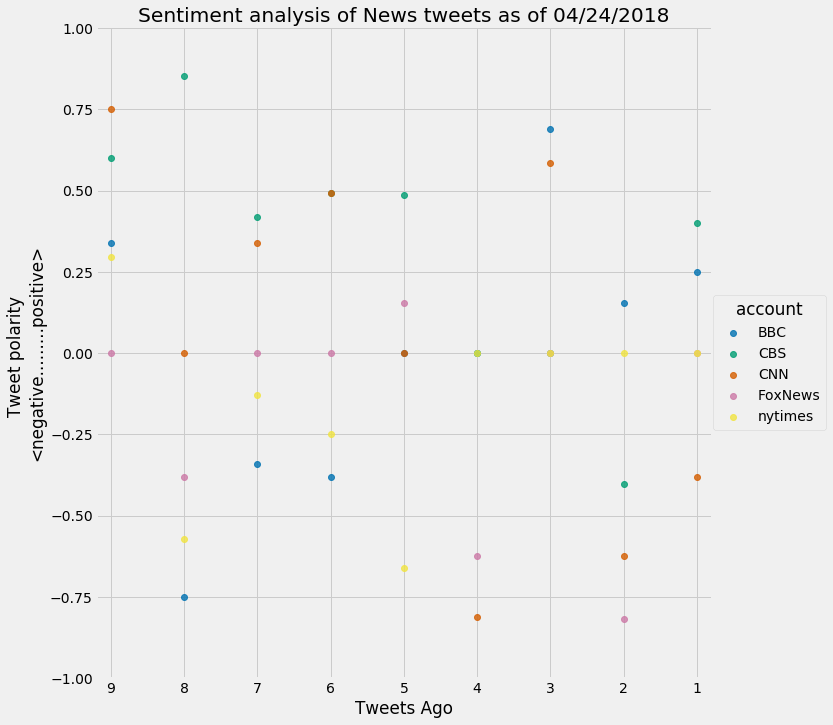

In [166]:
userNames = ['BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes']
tweets = pd.DataFrame()
tweetsPerUser = 10
for userName in userNames:
    tweets = tweets.append(getTweets(userName,count=tweetsPerUser))
tweets['index'] = tweets.index
f = makeGraph(tweets,show=True)